## Setup the notebook

In [1]:
import os, sys
from pathlib import Path
import subprocess

try:
    import google.colab
    is_colab = True
except ImportError:
    is_colab = False

if is_colab:
    print("Running on Google Colab")
    from google.colab import userdata
    token = userdata.get('git_token')
    repo_dir = '/content/PitchAnalyzer_AI'
    subprocess.check_call(['git', 'clone', f'https://{token}@github.com/Blaku03/PitchAnalyzer_AI.git', repo_dir])
    subprocess.check_call(['pip', 'install', repo_dir], stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)
    video_path = Path(repo_dir) / 'sample_data' / '08fd33_4.mp4'
    output_path = Path(repo_dir) / 'output_videos' / f"{video_path.name}_annotated.mp4"
    os.makedirs(output_path.parent, exist_ok=True)
elif os.environ.get("KAGGLE_KERNEL_RUN_TYPE"):
    print("Running on Kaggle")
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    token = user_secrets.get_secret("git_token")
    repo_url = f"git+https://{token}@github.com/Blaku03/PitchAnalyzer_AI.git"
    subprocess.check_call(
        ["pip", "install", repo_url],
        stdout=subprocess.DEVNULL,
        stderr=subprocess.STDOUT
    )
    video_path = Path("/kaggle/input/pitchtest/08fd33_4.mp4")
    output_path = f"{video_path.name}_annotated.mp4"
else:
    print("Running locally")
    %load_ext autoreload
    %autoreload 2
    ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
    if ROOT not in sys.path:
        sys.path.insert(0, ROOT)
    video_path = Path("../sample_data/08fd33_4.mp4")
    output_path = f"../output_videos/{video_path.name}_annotated.mp4"
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

Running on Google Colab


## Import models

In [2]:
from utils.import_models import ModelImporter
field_model = ModelImporter().download_pitch_model()
players_model = ModelImporter().download_player_model()


  0%|          | 0.00/134M [00:00<?, ?B/s]
  4%|▎         | 5.00M/134M [00:00<00:02, 49.9MB/s]
 11%|█         | 15.0M/134M [00:00<00:01, 81.2MB/s]
 22%|██▏       | 30.0M/134M [00:00<00:01, 99.2MB/s]
 34%|███▍      | 46.0M/134M [00:00<00:00, 122MB/s] 
 43%|████▎     | 58.0M/134M [00:00<00:00, 103MB/s]
 53%|█████▎    | 71.0M/134M [00:00<00:00, 111MB/s]
 67%|██████▋   | 90.0M/134M [00:00<00:00, 136MB/s]
 78%|███████▊  | 104M/134M [00:00<00:00, 124MB/s] 
 88%|████████▊ | 117M/134M [00:01<00:00, 119MB/s]
100%|██████████| 134M/134M [00:01<00:00, 108MB/s] 


Model downloaded to /root/.cache/kagglehub/models/blaku03/player-detection/pyTorch/pitch_detection/1
Model file location at /root/.cache/kagglehub/models/blaku03/player-detection/pyTorch/pitch_detection/1/v1_0.pt



  0%|          | 0.00/109M [00:00<?, ?B/s]
  5%|▌         | 6.00M/109M [00:00<00:01, 60.8MB/s]
 18%|█▊        | 20.0M/109M [00:00<00:01, 77.4MB/s]
 37%|███▋      | 40.0M/109M [00:00<00:00, 122MB/s] 
 53%|█████▎    | 58.0M/109M [00:00<00:00, 144MB/s]
 69%|██████▊   | 75.0M/109M [00:00<00:00, 153MB/s]
 83%|████████▎ | 91.0M/109M [00:00<00:00, 151MB/s]
100%|██████████| 109M/109M [00:00<00:00, 125MB/s]

Model downloaded to /root/.cache/kagglehub/models/blaku03/player-detection/pyTorch/player_detection/3
Model file location at /root/.cache/kagglehub/models/blaku03/player-detection/pyTorch/player_detection/3/v1_3.pt


In [3]:
%pwd

'/content'

## Demo of the field mapper


0: 544x960 1 pitch, 47.9ms
Speed: 3.1ms preprocess, 47.9ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 960)

0: 544x960 1 pitch, 46.8ms
Speed: 2.9ms preprocess, 46.8ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 960)


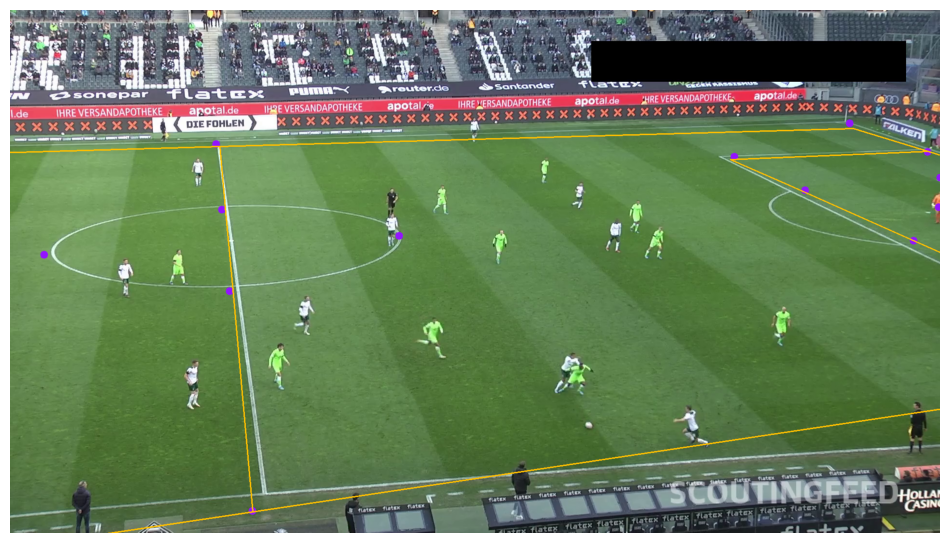

In [ ]:
from utils.notebook_utils import show_image
from utils.video_utils import read_video
from trackers.pitch_tracker import PitchTracker
from annotators.pitch_annotator import PitchAnnotator

frame_generator = read_video(video_path)
first_frame = next(frame_generator)

pitch_tracker = PitchTracker(field_model)
pitch_keypoints, confidence_mask = pitch_tracker.get_pitch_keypoints(first_frame)
pitch_edges = pitch_tracker.get_pitch_edges(first_frame)

show_image(PitchAnnotator.annotate_frame(first_frame.copy(), (pitch_keypoints,pitch_edges)))


0: 544x960 1 pitch, 43.0ms
Speed: 3.2ms preprocess, 43.0ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 960)


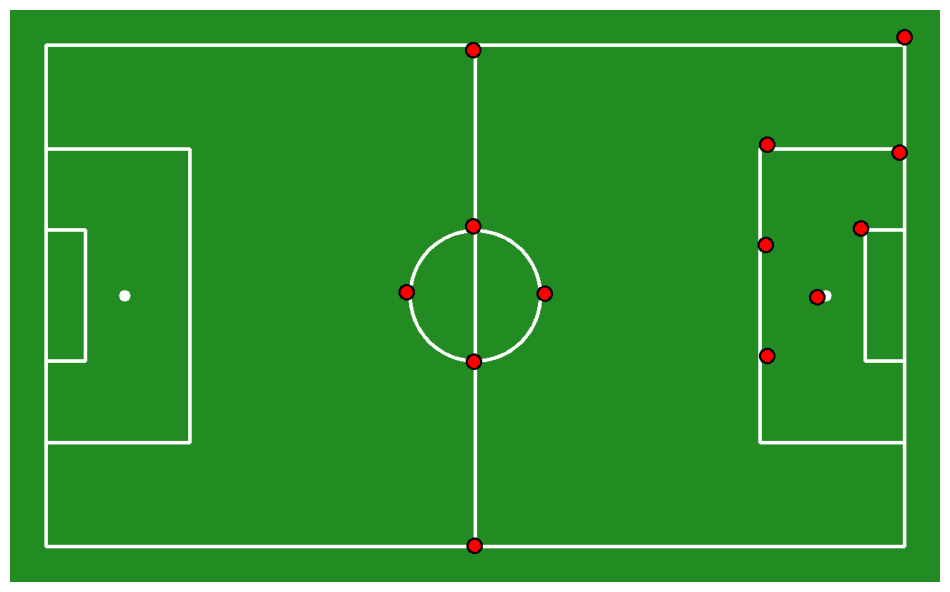

In [ ]:
from utils.pitch_utils import draw_pitch, draw_points_on_pitch
from mapping_2d.soccer_field import SoccerPitchConfiguration
import supervision as sv

mapped_vert = pitch_tracker.map_points_2d(first_frame, pitch_keypoints.xy[0])

pitch_img = draw_pitch(SoccerPitchConfiguration())
pitch_img = draw_points_on_pitch(
    config=SoccerPitchConfiguration(),
    xy=mapped_vert.xy[0],
    face_color=sv.Color.BLUE,
    edge_color=sv.Color.BLACK,
    radius=10,
    pitch=pitch_img)

show_image(pitch_img)

## Draw detected players on the 2d plane


0: 736x1280 22 players, 3 referees, 66.3ms
1: 736x1280 1 goalkeeper, 20 players, 3 referees, 66.3ms
2: 736x1280 1 goalkeeper, 21 players, 3 referees, 66.3ms
3: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 66.3ms
4: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 66.3ms
5: 736x1280 1 goalkeeper, 20 players, 3 referees, 66.3ms
6: 736x1280 1 ball, 21 players, 3 referees, 66.3ms
7: 736x1280 1 ball, 22 players, 1 referee, 66.3ms
8: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 66.3ms
9: 736x1280 1 ball, 22 players, 4 referees, 66.3ms
Speed: 6.2ms preprocess, 66.3ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 66.4ms
1: 736x1280 1 ball, 1 goalkeeper, 21 players, 3 referees, 66.4ms
2: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 66.4ms
3: 736x1280 1 ball, 2 goalkeepers, 21 players, 3 referees, 66.4ms
4: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 66.4ms
5: 736x1280 1

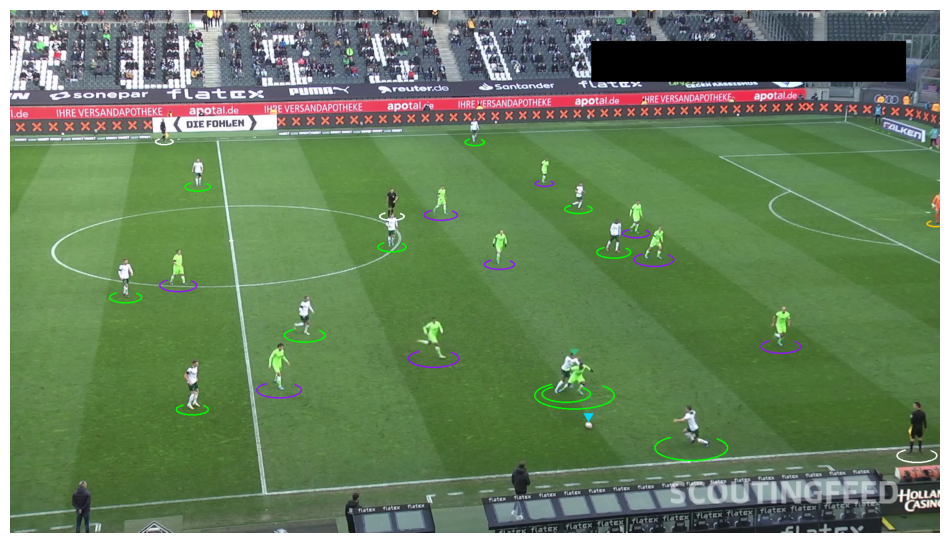

In [ ]:
from annotators.game_entities_annotator import GameEntitiesAnnotator
from trackers.game_tracker import GameTracker

frame_generator = read_video(video_path)
tracks_generator =  GameTracker(players_model).get_detections_generator(frame_generator)

first_frame = next(frame_generator)
first_players_tracks = next(tracks_generator)

annotated_sample_image = GameEntitiesAnnotator.annotate_frame(first_frame.copy(), first_players_tracks)
show_image(annotated_sample_image)


0: 544x960 1 pitch, 43.0ms
Speed: 3.5ms preprocess, 43.0ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 960)


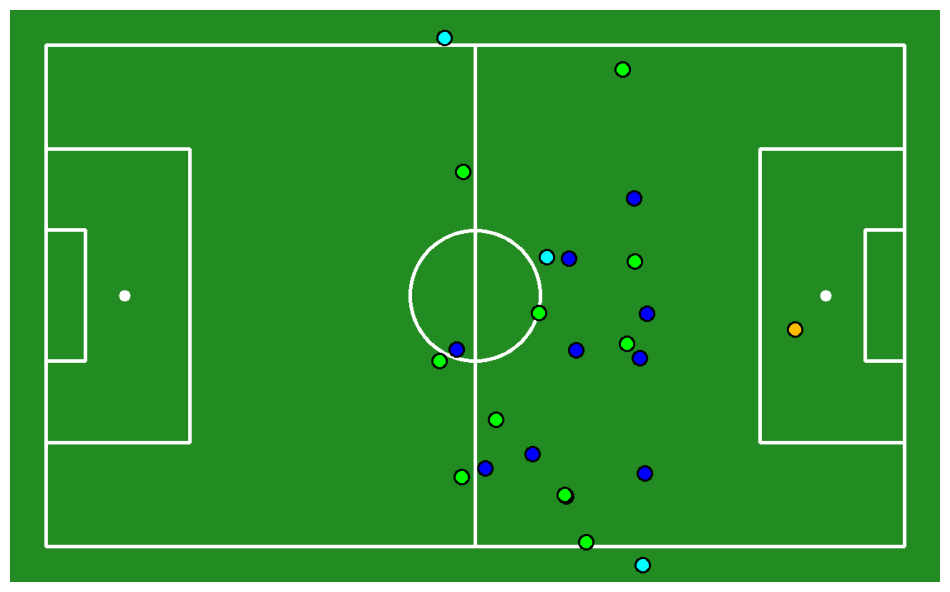

In [ ]:
from annotators.pitch_2d_annotator import Pitch2DAnnotator

bottom_boxes = first_players_tracks.players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
mapped_2d_points = pitch_tracker.map_points_2d(first_frame, bottom_boxes)

show_image(Pitch2DAnnotator().annotate_frame(mapped_2d_points.xy[0], first_players_tracks))

In [ ]:
# Annotate the full video
from utils.video_utils import save_video
import itertools

frame_generator = read_video(video_path)
frame_gen1, frame_gen2 = itertools.tee(frame_generator)

tracks_generator =  GameTracker(players_model).get_detections_generator(frame_gen1)
tracks_gen1, tracks_gen2 = itertools.tee(tracks_generator)

mapped_2d_points_generator = pitch_tracker.map_players_tracks_2d_generator(frame_gen2, tracks_gen1)
annotated_2d_field_generator = Pitch2DAnnotator().annotate_video(mapped_2d_points_generator, tracks_gen2)
save_video(annotated_2d_field_generator, output_path)


0: 736x1280 1 ball, 23 players, 4 referees, 65.9ms
1: 736x1280 1 ball, 22 players, 3 referees, 65.9ms
2: 736x1280 1 ball, 1 goalkeeper, 19 players, 2 referees, 65.9ms
3: 736x1280 1 ball, 21 players, 3 referees, 65.9ms
4: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 65.9ms
5: 736x1280 1 goalkeeper, 20 players, 3 referees, 65.9ms
6: 736x1280 22 players, 3 referees, 65.9ms
7: 736x1280 1 ball, 22 players, 3 referees, 65.9ms
8: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 65.9ms
9: 736x1280 1 ball, 20 players, 4 referees, 65.9ms
Speed: 6.0ms preprocess, 65.9ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 66.3ms
1: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 66.3ms
2: 736x1280 1 ball, 1 goalkeeper, 21 players, 3 referees, 66.3ms
3: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 66.3ms
4: 736x1280 1 ball, 2 goalkeepers, 21 players, 3 referees, 66.3ms
5: 736x1280 1 ball, 1 go

750